In [41]:
# set the path
import os
path= os.getcwd()

if path.endswith("notebooks"):
    os.chdir("../")
else:
    print("we are at correct path")

we are at correct path


In [59]:
# import dependencies
import joblib
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

from src.config import settings
from src.database import fetch_data
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [43]:

# fetch the data now
data= fetch_data(table_name= settings.table_name)

In [44]:
data.head(4)

,driver_age,gender,marital_status,occupation,employment_status,income_band,licence_years,ncd_years,age_band,ncd_band,vehicle_make,vehicle_year,vehicle_age,vehicle_body_type,fuel_type,gearbox_type,engine_cc,abi_group,abi_band,car_value,car_value_band,car_value_to_income_proxy,inception_date,policy_term_months,exposure_years,cover_type,use_type,annual_mileage,mileage_band,overnight_parking,voluntary_excess,compulsory_excess,payment_method,total_claim_cost,risk_premium,technical_premium,quoted_premium,convictions,fault_claims,nonfault_claims,total_claims,claims_per_year_of_licence,young_driver_flag,senior_driver_flag,high_mileage_flag,luxury_brand_flag,urban_flag,high_excess_flag,monthly_pay_flag,multi_claims_flag
0,68,Female,Single,Commercial/residential surveyor,Self-Employed,Low,51,15.0,Elderly,Very High,Audi,2021,4,SUV,Petrol,Automatic,1000,1,Very Low,35333.97,Luxury,0.4596,2025-10-18,12,1,Third party fire and theft,Social,5486,Average,Driveway,0,150,Monthly,0,0,0,1801.44,0,0,0,0,0,0,0,0,0,1,0,1,0
1,31,Female,Divorced,administration,Self-Employed,Moderate,13,12.5,Adult,Very High,Mercedes,2009,16,Hatchback,Petrol,Manual,1600,1,Very Low,48506.02,Luxury,1.5589,2024-12-30,12,1,Comprehensive,Business,5584,Average,Street,250,150,Annual,0,0,0,421.90,0,0,0,0,0,0,0,0,0,0,0,1,0
2,77,Female,Single,"Surveyor, commercial/residential",Self-Employed,High,58,15.0,Elderly,Very High,Ford,2010,15,SUV,Petrol,Automatic,1000,47,Very High,40958.77,Luxury,1.0098,2025-09-27,12,1,Third party fire and theft,Social,11588,High,Garage,0,150,Annual,0,0,0,936.37,0,0,0,0,0,0,0,0,0,1,0,0,0
3,37,Male,Widowed,Copy,Student,Moderate,18,15.0,Mid-age,Very High,Audi,2023,2,SUV,Hybrid,Automatic,3000,34,High,44584.49,Luxury,0.8609,2025-05-20,12,1,Third party only,Social,13829,High,Locked Compound,0,150,Monthly,0,0,0,947.50,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
# at this point inception date is not useful in future we can check policy age by it inception date - crrent date.
# so drop it
data.drop(columns= "inception_date", axis=1, inplace= True)

### Modeling

**Note**: We are going to create gbm models and compare them.


In [46]:
# as gbm models can handle categorical columns we will convert the cols into cateogry type.

# iterate over the columns
for column in data.select_dtypes(include= "O"):
    # convert the datatype into category
    data[column]= data[column].astype("category")

In [47]:
# lets split the data into features and target column

x= data.drop(columns= ["quoted_premium"], axis=1)
y= data["quoted_premium"]

In [48]:
# split the data into train test split
x_train, x_test, y_train, y_test= train_test_split(
    x, y, test_size= 0.2, random_state= 42
)

In [49]:
# train the model
model= LGBMRegressor()

model.fit(
    x_train, y_train, categorical_feature= [
        col for col in data.columns if data[col].dtype == "category"
    ]
)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [50]:
# lets check the scores on training data
y_train_pred = model.predict(x_train)

# Calculate metrics
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mae_train= mean_absolute_error(y_train, y_train_pred)

print("Training MSE:", mse_train)
print("Training R²:", r2_train)
print("Traning MAE", mae_train)

# lets check the scores on testing data
y_test_pred = model.predict(x_test)

# Calculate metrics
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test= mean_absolute_error(y_test, y_test_pred)

print("Training MSE:", mse_test)
print("Training R²:", r2_test)
print("Traning MAE", mae_test)

Training MSE: 22313.555950021826
Training R²: 0.9398687626839362
Traning MAE 121.82136867872185
Training MSE: 484239.60743138334
Training R²: -0.2512351135895019
Traning MAE 591.2157047258486


### Feature Selection


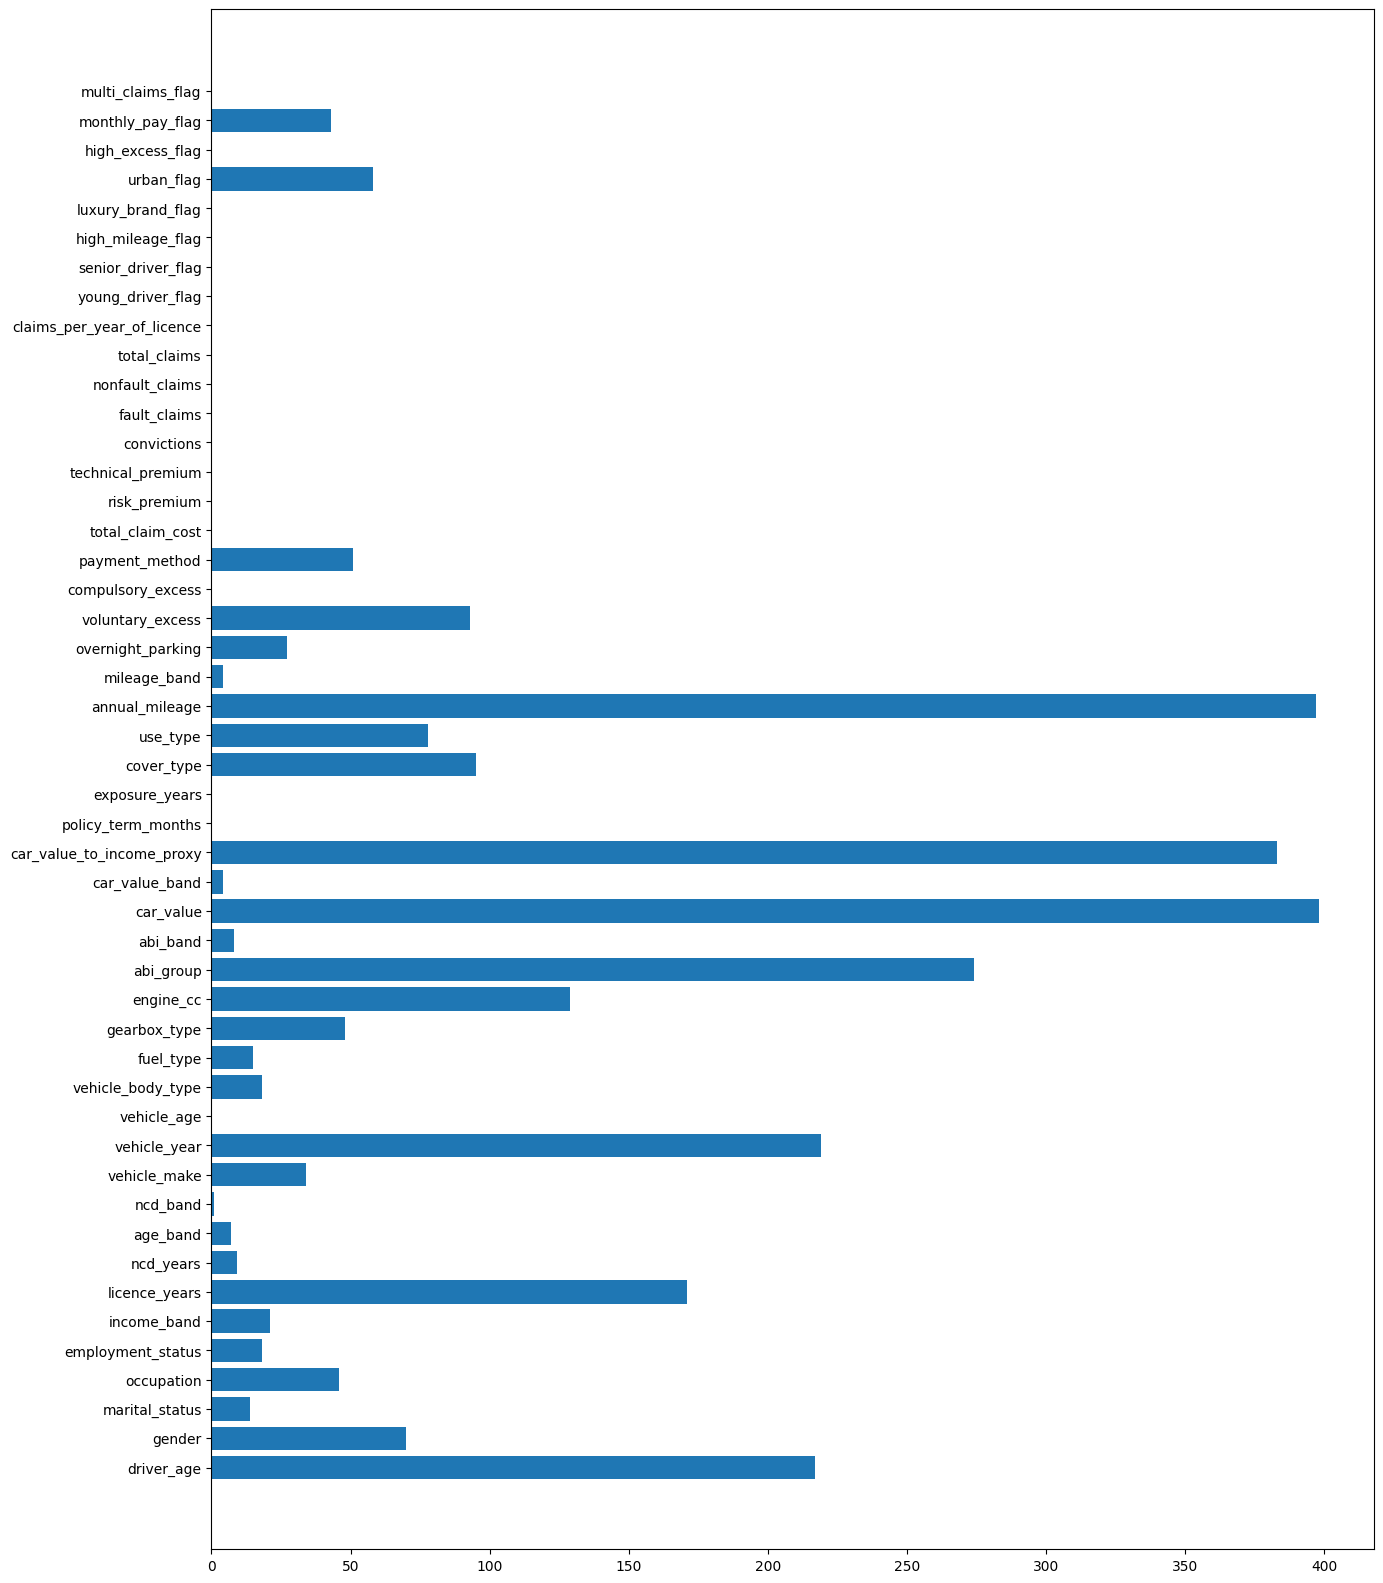

In [51]:
# get the feature importance
importance= model.feature_importances_
feature_names= model.feature_name_
plt.figure(figsize= (15, 20))
plt.barh(feature_names, importance)
plt.show()

In [52]:
# Now train the model with selected features which have high importance
top_features = x_train.columns[model.feature_importances_ > 10]  # use the model's feature importances
X_train_selected = x_train[top_features]
X_test_selected = x_test[top_features]

# Select categorical features among top features
cat_features = [f for f in X_train_selected.columns if X_train_selected[f].dtype.name == "category"]

# Train model
model.fit(X_train_selected, y_train, categorical_feature=cat_features)


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [57]:
X_train_selected.head(3)

,driver_age,gender,marital_status,occupation,employment_status,income_band,licence_years,vehicle_make,vehicle_year,vehicle_body_type,fuel_type,gearbox_type,engine_cc,abi_group,car_value,car_value_to_income_proxy,cover_type,use_type,annual_mileage,overnight_parking,voluntary_excess,payment_method,urban_flag,monthly_pay_flag
29,71,Female,Single,art,Retired,Good,52,Mercedes,2023,Saloon,Hybrid,Automatic,1200,46,18923.62,0.4143,Comprehensive,Business,17537,Garage,100,Monthly,1,1
535,68,Male,Married,art,Retired,High,50,Audi,2021,Coupe,Hybrid,Automatic,1000,39,42660.75,1.0846,Third party fire and theft,Social,3509,Driveway,250,Monthly,0,1
695,30,Female,Married,engineer,Student,High,13,Mercedes,2009,Hatchback,Hybrid,Automatic,1000,8,48251.17,1.4012,Third party only,Social,2739,Locked Compound,250,Monthly,1,1


In [58]:
X_train_selected.dtypes

driver_age                      int64
gender                       category
marital_status               category
occupation                   category
employment_status            category
income_band                  category
licence_years                   int64
vehicle_make                 category
vehicle_year                    int64
vehicle_body_type            category
fuel_type                    category
gearbox_type                 category
engine_cc                       int64
abi_group                       int64
car_value                     float64
car_value_to_income_proxy     float64
cover_type                   category
use_type                     category
annual_mileage                  int64
overnight_parking            category
voluntary_excess                int64
payment_method               category
urban_flag                      int64
monthly_pay_flag                int64
dtype: object

In [53]:
len(model.feature_name_)

24

In [54]:
# lets check the scores on training data
y_train_pred = model.predict(X_train_selected)

# Calculate metrics
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
mae= mean_absolute_error(y_train, y_train_pred)

print("Training MSE:", mse)
print("Training R²:", r2)
print("Traning MAE", mae)

Training MSE: 22985.79625675772
Training R²: 0.9380571894184155
Traning MAE 123.9570582912653


In [55]:
# lets check the scores on testing data
y_test_pred = model.predict(X_test_selected)

# Calculate metrics
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test= mean_absolute_error(y_test, y_test_pred)

print("Training MSE:", mse_test)
print("Training R²:", r2_test)
print("Traning MAE", mae_test)

Training MSE: 463608.25723702344
Training R²: -0.19792541027779453
Traning MAE 580.2082505944044


In [63]:
# lets save the model

# create a model directory if not exists
os.makedirs("model", exist_ok=True)
joblib.dump(model, filename="model/model.joblib")

['model/model.joblib']

In [64]:
data.head(1)

,driver_age,gender,marital_status,occupation,employment_status,income_band,licence_years,ncd_years,age_band,ncd_band,vehicle_make,vehicle_year,vehicle_age,vehicle_body_type,fuel_type,gearbox_type,engine_cc,abi_group,abi_band,car_value,car_value_band,car_value_to_income_proxy,policy_term_months,exposure_years,cover_type,use_type,annual_mileage,mileage_band,overnight_parking,voluntary_excess,compulsory_excess,payment_method,total_claim_cost,risk_premium,technical_premium,quoted_premium,convictions,fault_claims,nonfault_claims,total_claims,claims_per_year_of_licence,young_driver_flag,senior_driver_flag,high_mileage_flag,luxury_brand_flag,urban_flag,high_excess_flag,monthly_pay_flag,multi_claims_flag
0,68,Female,Single,Commercial/residential surveyor,Self-Employed,Low,51,15.0,Elderly,Very High,Audi,2021,4,SUV,Petrol,Automatic,1000,1,Very Low,35333.97,Luxury,0.4596,12,1,Third party fire and theft,Social,5486,Average,Driveway,0,150,Monthly,0,0,0,1801.44,0,0,0,0,0,0,0,0,0,1,0,1,0


In [66]:
# Sample input for API prediction
sample_input = {
    "driver_age": 35,
    "gender": "M",
    "martial_status": "Single",
    "occupation": "Engineer",
    "employment_status": "Employed",
    "income_band": "30000-50000",
    "licence_years": 10,
    "vehicle_make": "Toyota",
    "vehicle_year": 2020,
    "vehicle_body_type": "Sedan",
    "fuel_type": "Petrol",
    "gearbox_type": "Manual",
    "engine_cc": 1600,
    "abi_group": 5,
    "car_value": 15000.0,
    "car_value_to_income_proxy": 0.5,
    "cover_type": "Comprehensive",
    "use_type": "Commute",
    "annual_mileage": 12000,
    "overnight_parking": "Garage",
    "voluntary_excess": 500,
    "payment_method": "Monthly",
    "urban_flag": 1,
    "monthly_pay_flag": 1
}

print("Sample API input:")
print(sample_input)

Sample API input:
{'driver_age': 35, 'gender': 'M', 'martial_status': 'Single', 'occupation': 'Engineer', 'employment_status': 'Employed', 'income_band': '30000-50000', 'licence_years': 10, 'vehicle_make': 'Toyota', 'vehicle_year': 2020, 'vehicle_body_type': 'Sedan', 'fuel_type': 'Petrol', 'gearbox_type': 'Manual', 'engine_cc': 1600, 'abi_group': 5, 'car_value': 15000.0, 'car_value_to_income_proxy': 0.5, 'cover_type': 'Comprehensive', 'use_type': 'Commute', 'annual_mileage': 12000, 'overnight_parking': 'Garage', 'voluntary_excess': 500, 'payment_method': 'Monthly', 'urban_flag': 1, 'monthly_pay_flag': 1}
